In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
from sqlalchemy import text

plt.style.use("ggplot")

# TEOTIL2: Contributions from VEAS

Notebook estimating what proportion of the TOTN and TOTP delivered to the Inner Oslofjord comes from the large wastewater site at VEAS.

 * The Inner Oslojord is the area within Drøbak i.e. vassdragsområder 005, 006, 007, 008 and 009
 * VEAS has site ID `0220AL01` and discharges directly to the fjord

In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


In [3]:
# Get TOTN and TOTP data for VEAS
site_id = "0220AL01"
sql = text(
    "SELECT anlegg_nr as site_id, "
    "  inp_par_id, "
    "  year, "
    "  value "
    "FROM resa2.rid_punktkilder_inpar_values "
    "WHERE anlegg_nr = :site_id "
    "AND inp_par_id IN (44, 45) "
    "ORDER BY year"
)
veas_df = pd.read_sql(sql, eng, params={"site_id": site_id})
par_map = {44: "TOTN_kg", 45: "TOTP_kg"}
veas_df["par_unit"] = veas_df["inp_par_id"].map(par_map)
del veas_df["inp_par_id"]
veas_df = veas_df.pivot(
    index=["site_id", "year"], columns="par_unit", values="value"
).reset_index()
del veas_df["site_id"]
veas_df.set_index("year", inplace=True)
veas_df = veas_df / 1000
veas_df.columns = ["VEAS_TOTN_tonnes", "VEAS_TOTP_tonnes"]
veas_df.head()

,VEAS_TOTN_tonnes,VEAS_TOTP_tonnes
year,,
1993,1601.000,36.593
1994,720.000,25.000
1995,2081.560,39.078
1996,820.304,39.046
1997,820.304,39.046


In [4]:
# Get TEOTIL2 results for vassoms 5 to 9
st_yr, end_yr = 1990, 2021
vassom_min, vassom_max = 5, 9
cols = ["accum_all_sources_tot-n_tonnes", "accum_all_sources_tot-p_tonnes"]
vassom_list = [f"{vassom:03d}." for vassom in range(vassom_min, vassom_max + 1)]

df_list = []
for year in range(st_yr, end_yr + 1):
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_output_data/teotil2_results_{year}.csv"
    df = pd.read_csv(url)
    df = df.query("regine in @vassom_list")
    df = df[cols]
    df["year"] = year
    df_list.append(df)
df = pd.concat(df_list, axis="rows")
df = df.groupby("year").sum()
df = df[cols]
df.columns = ["InnerOF_TOTN_tonnes", "InnerOF_TOTP_tonnes"]

# Combine with VEAS data
df = pd.concat([df, veas_df], axis="columns")

# Calculate proportion from VEAS
pars = ["TOTN", "TOTP"]
for par in pars:
    df[f"VEAS_{par}_pct"] = 100 * df[f"VEAS_{par}_tonnes"] / df[f"InnerOF_{par}_tonnes"]

# Save
csv_path = r"../data/teotil2_prop_inner_oslofjord_nutrients_from_veas.csv"
df.to_csv(csv_path)

df

,InnerOF_TOTN_tonnes,InnerOF_TOTP_tonnes,VEAS_TOTN_tonnes,VEAS_TOTP_tonnes,VEAS_TOTN_pct,VEAS_TOTP_pct
year,,,,,,
1990,932.135349,30.133481,NaN,NaN,NaN,NaN
1991,939.369925,29.328410,NaN,NaN,NaN,NaN
1992,820.581615,29.551212,NaN,NaN,NaN,NaN
1993,3650.219052,94.200881,1601.000000,36.59300,43.860381,38.845709
1994,2125.256636,62.225574,720.000000,25.00000,33.878261,40.176407
1995,3985.180709,86.367228,2081.560000,39.07800,52.232512,45.246329
1996,3066.822903,102.394743,820.304000,39.04600,26.747681,38.132817
1997,3096.621423,98.973946,820.304000,39.04600,26.490290,39.450786
1998,2919.801747,81.371569,729.048000,33.68280,24.969093,41.393819


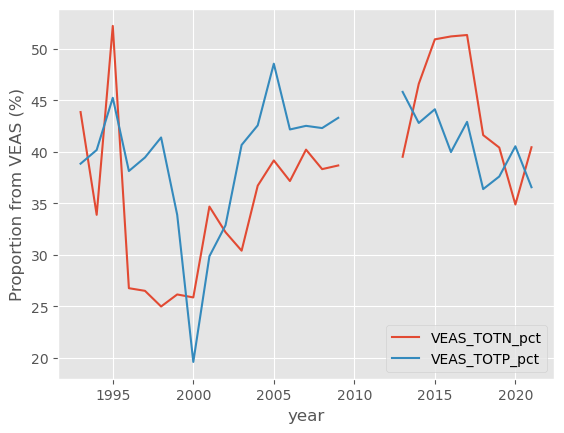

In [5]:
# Plot
cols = [col for col in df.columns if col.endswith("_pct")]
ax = df[cols].plot()
ax.set_ylabel("Proportion from VEAS (%)");